<a href="https://colab.research.google.com/github/hadareanalex/pydata-book/blob/1st-edition/MIB2021_lab05_06_resolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laborator 05-06

În laboratorul trecut am observat cum rezultatul metodelor hill climbing depinde foarte mult de punctul de pornire și de parametrizare. Un alt algoritm stohastic, ce poate oferi o mai bună balanță între explorare și exploatare și o independență în cea ce privește punctul de start este inspirat din călirea metalurgică. Încălzirea urmată de răcirea controlată a unui material rezultă în creșterea dimensiunii cristalelor și reduce defectele structurale.


![](https://image.slidesharecdn.com/f-annealing-131118222251-phpapp02/95/annealing-39-638.jpg?cb=1384813935)

Fig. 1. Exemplificarea procesului de cristalizare prin călire. [Sursa imaginii](https://www.slideshare.net/RakeshSingh125/f-annealing). 


Inițial, prin creșterea temperaturii, [căldura dislocă atomii](https://www.sciencelearn.org.nz/resources/750-heat-energy) din poziţiile fixe (minim local) şi permite acestora să [viziteze aleatoriu stări cu energie mai ridicată](https://www.youtube.com/watch?v=qW59Y9lJso8). Apoi, o răcire graduală și lentă acordă timp și implicit mai multe şanse atomilor dislocați să găsească o configuraţie mai bună, cu o energie internă mai mică decât cea iniţială.


## Călirea simulată

Călirea simulată, denumit în engleză [Simulated Annealing](https://en.wikipedia.org/wiki/Simulated_annealing), este o metodă stocastică pentru aproximarea optimului global al unei funcții, ce permite la fiecare pas trecerea într-o stare inferioară (soluție mai slabă calitativ) cu o probabilitate direct proporțională cu "temperatura" (simulată) actuală (linia 13, pseudocod fig. 2). 

Metoda pornește cu o temperatură inițială ridicată și tinde în timp la 0, conform unui program de răcire (o funcție monoton descrescătoare, `calculate_tempereature(i)` - linia 7, pseudocod fig. 2).). Astfel la început, probabilitatea acceptării a unor stări inferioare este foarte mare, algoritmul poate ușor ieși din vecinătatea unui optim local. În această fază metoda probează spațiul de căutare în mod aleatoriu, traiectoria descrisă este haotică ([random walk](https://www.mit.edu/~kardar/teaching/projects/chemotaxis(AndreaSchmidt)/random.htm)), explorarea este maximă. Scăderea graduală a temperaturii induce o focusare din ce în ce mai pronunțată spre îmbunătățire, o trecere graduală de la explorare accentuată spre exploatare accentuată. În această fază comportamentul metodei se aseamănă cu [coborârea cu gradient stocastic](https://arxiv.org/abs/1609.04747) ([stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)). În final, la temperaturi scăzute, probabilitatea acceptării unei soluții inferioare devine minusculă (dar nu 0, imposibilă), metoda este axată pe exploatare.

![](https://d3i71xaburhd42.cloudfront.net/9f01f2a70d64f2abbbf8d8a75d340a7f27586a25/8-Figure3-1.png)

Fig. 2. Pseudocod pentru metoda călirii simulate. [Sursa imaginii](https://link.springer.com/article/10.1007/s00500-016-2067-4).

Cu un program de răcire suficient de lung (teoretic infinit) și lent (cu suficiente iterații la fiecare nivel de temperatură), algoritmul garantează găsirea optimului global, din păcate într-un număr exponențial de pași în raport cu dimensiunea problemei

Pentru obținerea unor rezultate bune, în practică trebuie bine echilibrată tranziția de la explorare spre exploatare. În cazul unei funcții obiectiv extrem de multimodal, folosirea unui program de răcire prea agresiv poate duce la o "înghețare" prematură, blocare într-un minim local. Utilizarea unui program de răcire mai lent scade probabilitatea convergenței premature într-un minim local, însă ea necesită cerințe de calcul crescute.


# Exemplu optimizare

Considerăm problema [comis-voiajorului](https://ro.wikipedia.org/wiki/Problema_comis-voiajorului) pentru cele mai mari 20 de orașe din SUA, folosind o [implementație a metodei în Python](https://github.com/perrygeo/simanneal).

In [1]:
!pip install simanneal

In [2]:
from simanneal import Annealer
import math

In [3]:
def geographicDistance(a, b):
    """Calculates distance between two latitude-longitude coordinates."""
    R = 6378.1  # equatorial radius of Earth https://imagine.gsfc.nasa.gov/features/cosmic/earth_info.html
    lat1, lon1 = math.radians(a[0]), math.radians(a[1])
    lat2, lon2 = math.radians(b[0]), math.radians(b[1])
    return math.acos(math.sin(lat1) * math.sin(lat2) +
                     math.cos(lat1) * math.cos(lat2) * math.cos(lon1 - lon2)) * R

In [4]:
class TravellingSalesmanProblem(Annealer):
    """Test annealer with a travelling salesman problem."""
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  

    def move(self):
        """Swaps two cities in the route."""
        initial_energy = self.energy()

        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

        return self.energy() - initial_energy

    def energy(self):
        """Calculates the length of the route."""
        e = 0
        for i in range(len(self.state)):
            e += self.distance_matrix[self.state[i-1]][self.state[i]]
        return e

In [5]:
# latitude and longitude for the twenty largest U.S. cities
# https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

cities = {
        'New York City': (40.72, 74.00),
        'Los Angeles': (34.05, 118.25),
        'Chicago': (41.88, 87.63),
        'Houston': (29.77, 95.38),
        'Phoenix': (33.45, 112.07),
        'Philadelphia': (39.95, 75.17),
        'San Antonio': (29.53, 98.47),
        'Dallas': (32.78, 96.80),
        'San Diego': (32.78, 117.15),
        'San Jose': (37.30, 121.87),
        'Detroit': (42.33, 83.05),
        'San Francisco': (37.78, 122.42),
        'Jacksonville': (30.32, 81.70),
        'Indianapolis': (39.78, 86.15),
        'Austin': (30.27, 97.77),
        'Columbus': (39.98, 82.98),
        'Fort Worth': (32.75, 97.33),
        'Charlotte': (35.23, 80.85),
        'Memphis': (35.12, 89.97),
        'Baltimore': (39.28, 76.62)
    }

In [6]:
import random
# initial state, a randomly-ordered itinerary
init_state = list(cities)
random.shuffle(init_state)
print(init_state)

['Columbus', 'Indianapolis', 'San Antonio', 'Dallas', 'Baltimore', 'Houston', 'Austin', 'San Francisco', 'San Diego', 'San Jose', 'Fort Worth', 'Phoenix', 'Memphis', 'Los Angeles', 'New York City', 'Jacksonville', 'Charlotte', 'Philadelphia', 'Detroit', 'Chicago']


In [7]:
from collections import defaultdict
# create an adjacency matrix - https://en.wikipedia.org/wiki/Adjacency_matrix
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
  for kb, vb in cities.items():
    distance_matrix[ka][kb] = 0.0 if kb == ka else geographicDistance(va, vb)

print('The distance from New York to Houston is {0} kms.'.format(distance_matrix['New York City']['Houston']))

The distance from New York to Houston is 2284.807991009479 kms.


Confirm with Google:

https://www.google.com/search?client=safari&rls=en&q=distance+new+york+to+houston&ie=UTF-8&oe=UTF-8

![](https://www.google.com/maps/vt/data=6dwNcCGg2G7qCjzYYqmJEvOdwo3PgE9W1cAWPqOISd3KCjFsBMSOiQAICYx0I_jjWmQris4hQePQoQyrx4AlvoeJ_guXdArgnA6Kpte8Na4_RaUTcT_tLLnd4FCx5ITouhQKjNDCLdh3qLx409QSRDMKlxA4eVsp4p7wl__yGnMO1ronpZAjHtKBnmAd,3-zgxN7akVijwp6XwwoZFPZqIq2xWsAQvVlfYY3ZjKSbZlcBxOF74y4qPLf3M0G5_JzyiXpogRqPH290MBSfK418Y3GbASjpkdz5cCQy7FiGqCuKVcZ_vTPr_-IHYnfv0wWQvsLGp0J3AYXrnST-yz_SxrfYVOzvd4mjgNBnwDibdQxoFT6iHnfaq7zLTyAig23Lt-ehVUkeWySw-dCNCv1RGCFnmUqpgoS0Y278AqbMlfpxTCdmQdsEKURB7RfZ8YTFTXslG9tcd6WV-N62Y8t4PJEalDmQUOgaLbrG_aK71_ZYUn_0hW8PYxtH4VFxt4ZMaxtZ_8J__w63usk9rXfT184R6ndQE6_CpwFArJF_uXI0WkZXIDZmKVBXZX5bO_y1GLM?scale=2&h=200&w=618)

In [8]:
tsp = TravellingSalesmanProblem(init_state, distance_matrix)
tsp.set_schedule(tsp.auto(minutes = 1))

tsp.copy_strategy = 'slice'
state, e = tsp.anneal()

while state[0] != 'New York City':
    state = state[1:] + state[:1]  # rotate NYC to start

print()
print("%i km route:" % e)
print(" ➞  ".join(state))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining



10946 km route:
New York City ➞  Detroit ➞  Columbus ➞  Indianapolis ➞  Chicago ➞  San Francisco ➞  San Jose ➞  Los Angeles ➞  San Diego ➞  Phoenix ➞  San Antonio ➞  Austin ➞  Houston ➞  Fort Worth ➞  Dallas ➞  Memphis ➞  Jacksonville ➞  Charlotte ➞  Baltimore ➞  Philadelphia


### Vizualizarea rutei obținute


In [9]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 4.2MB/s 
     |████████████████████████████████| 14.8MB 270kB/s 
     |████████████████████████████████| 6.5MB 22.5MB/s 


In [10]:
!pip install geoplot

     |████████████████████████████████| 14.4MB 327kB/s 
     |████████████████████████████████| 19.1MB 236kB/s 
     |████████████████████████████████| 225kB 55.0MB/s 
  Created wheel for cartopy: filename=Cartopy-0.18.0-cp37-cp37m-linux_x86_64.whl size=15127660 sha256=2b91a2d877dd1c59c4345c8a6aee652d8994dd7e60d73376a6c2fdc1f875b6cc
  Stored in directory: /root/.cache/pip/wheels/8d/f8/da/2c05136f2162370d2baec85bfbbf91d7729ab9e248da878acd
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=1b368f8e11d8d66e4542a025a608824f5b2153a8c3dffddeaba7f36fae8f19fa
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built cartopy pyshp


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point, Polygon

In [12]:
df = pd.DataFrame(
    {'City': cities.keys(),
     'Latitude': [x[0] for x in cities.values()],
     'Longitude': [x[1] for x in cities.values()]})

df.head()

,City,Latitude,Longitude
0,New York City,40.72,74.00
1,Los Angeles,34.05,118.25
2,Chicago,41.88,87.63
3,Houston,29.77,95.38
4,Phoenix,33.45,112.07


In [13]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(-df.Longitude, df.Latitude), crs = 4326)

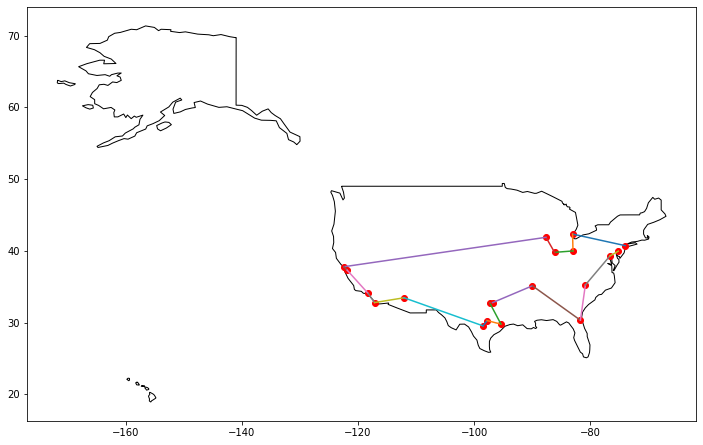

In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'United States of America'].plot(
    color='white', edgecolor='black', figsize=(12, 10))

gdf.plot(ax=ax,color='red')

for i in range(0, len(state)-1):
  plt.plot( [-df[df.City==state[i]].Longitude, -df[df.City==state[i+1]].Longitude], [df[df.City==state[i]].Latitude, df[df.City==state[i+1]].Latitude])

plt.show()

# Exerciții

1. Conform articolului ["On the Convergence Time of Simulated Annealing"](https://core.ac.uk/download/pdf/76359167.pdf) ce se poate afirma despre convergența metodei?
2. Care [programe de răcire](https://www.researchgate.net/publication/282449315_A_Comparative_Study_of_Simulated_Annealing_with_different_Cooling_Schedules_for_Geometric_Optimization_of_a_Heat_Transfer_Problem_According_to_Constructal_Design) (cooling schedule) sunt cel mai des folosite? La ce tipuri de probleme se pretează programele de răcire mai lente?
3. Conform [acestei](https://page.mi.fu-berlin.de/prechelt/Biblio/kangaroo_analogy.html) analogii amuzante, cum este descrisă dinamica călirii simulate? 
4. Cu ajutorul [`scipy.optimize.anneal`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.anneal.html) găsiți optimele funcțiilor studiate laboratorul precedent (conform exemplului din documentație - schimbați definiția funcției `f`). Cum se compară performanța cu strategiile de îmbunătățire iterativă, în cazul funcțiilor multimodale?
5. Rezolvați problema comis voiajorului pentru [municipiile de rang 0 din România](https://ro.wikipedia.org/wiki/Municipiile_României).
6. *Implementați (soluție proprie) metoda călirii simulate, exemplificați funcționalitatea pe o problemă aleasă.* **(opțional, punct în plus)**.

# ex1
 - Au arătat asta
acest algoritm converge în limită la o soluție optimă la nivel global cu probabilitatea 1.

# ex2
 - Rezultatele au arătat că programul de răcire hibrid este cele mai recomandat pentru a găsi configurațiile geometrice optime în căldură si
probleme de transfer în asociere cu Constructal Design (BoltzExp, ConstExp1 și ConstExp2).

# ex3
 - 
În recușire simulată, cangurul este beat și saltează în mod aleatoriu
pentru o lungă perioadă de timp. Cu toate acestea, el se trezește treptat și tinde să sară sus deal.
 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point, Polygon
from scipy.optimize import basinhopping

#ex4

In [16]:
def generateRandomSolution(xmin=-2, xmax=2, ymin=-2, ymax=2):
  x = random.uniform(xmin, xmax)
  y = random.uniform(ymin, ymax)

  return x, y

def objFuncUnimodal(point):
    return np.exp(-(point[0]*point[0]+point[1]*point[1]))

def objFuncMultimodal(point):
    return np.exp(-(point[0]*point[0]+point[1]*point[1])) + 2*np.exp(-( (point[0]-1.7)**2 + (point[1]-1.7)**2))

In [17]:
minimizer_kwargs = {"method": "BFGS"}

x,y = generateRandomSolution()

point = [x, y]

ret = basinhopping(objFuncUnimodal, point, minimizer_kwargs=minimizer_kwargs, niter=200)
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret.x[0], ret.x[1], ret.fun))

ret = basinhopping(objFuncMultimodal, point, minimizer_kwargs=minimizer_kwargs, niter=200)
print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (ret.x[0], ret.x[1], ret.fun))

global minimum: x = [7.5124, -6.4723], f(x0) = 0.0000
global minimum: x = [3.1364, -12.1200], f(x0) = 0.0000


#ex5

In [18]:
#Burucresti 44°26′7″N 26°6′10″E
#Bacau 46°35′0″N 26°55′0″E
#brasov 45°39′N 25°36′E
#braila 45°16′9″N 27°57′27″E
#galati 45°26′22″N 28°2′4″E
#cluj 46°46′0″N 23°35′0″E
#constanta 44°10′24″N 28°38′18″E
#craiova 44°20′N 23°49′E
#iasi 47°9′44″N 27°35′20″E
#oradea 47°04′20″N 21°55′16″E
#ploiesti 44°56′24″N 26°1′48″E
#timisoara 45°47′58″N 21°17′38″E

cities = {
        'Bucuresti': (44.26, 26.6),
        'Bacau': (46.35, 26.55),
        'Brasov': (45.39, 25.36),
        'Braila': (45.16, 27.57),
        'Galati': (45.26, 28.2),
        'Cluj-Napoca': (46.46, 23.35),
        'Constanta': (44.1, 28.38),
        'Craiova': (44.2, 23.49),
        'Iasi': (47.9, 27.35),
        'Oradea': (47.04, 21.55),
        'Ploiesti': (44.56, 26.1),
        'Timisoara': (45.47, 21.17),
    }

In [19]:
init_state = list(cities)
random.shuffle(init_state)
print(init_state)

['Braila', 'Bucuresti', 'Cluj-Napoca', 'Ploiesti', 'Craiova', 'Timisoara', 'Constanta', 'Iasi', 'Galati', 'Brasov', 'Oradea', 'Bacau']


In [20]:
from collections import defaultdict
# create an adjacency matrix - https://en.wikipedia.org/wiki/Adjacency_matrix
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
  for kb, vb in cities.items():
    distance_matrix[ka][kb] = 0.0 if kb == ka else geographicDistance(va, vb)

print('The distance from Timisoara to Iasi is {0} kms.'.format(distance_matrix['Timisoara']['Iasi']))

The distance from Timisoara to Iasi is 543.7277891100426 kms.


In [21]:
tsp = TravellingSalesmanProblem(init_state, distance_matrix)
tsp.set_schedule(tsp.auto(minutes = 1))

tsp.copy_strategy = 'slice'
state, e = tsp.anneal()

while state[0] != 'Timisoara':
    state = state[1:] + state[:1]  # rotate Timisoara to start

print()
print("%i km route:" % e)
print(" ➞  ".join(state))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining



1923 km route:
Timisoara ➞  Craiova ➞  Brasov ➞  Ploiesti ➞  Bucuresti ➞  Constanta ➞  Galati ➞  Braila ➞  Bacau ➞  Iasi ➞  Cluj-Napoca ➞  Oradea


In [22]:
df = pd.DataFrame(
    {'City': cities.keys(),
     'Latitude': [x[0] for x in cities.values()],
     'Longitude': [x[1] for x in cities.values()]})

df.head()

,City,Latitude,Longitude
0,Bucuresti,44.26,26.60
1,Bacau,46.35,26.55
2,Brasov,45.39,25.36
3,Braila,45.16,27.57
4,Galati,45.26,28.20


In [23]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = 4326)

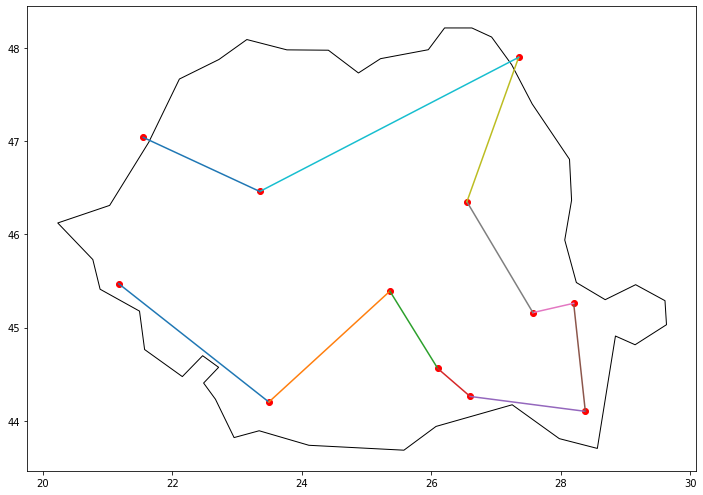

In [24]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'Romania'].plot(
    color='white', edgecolor='black', figsize=(12, 10))

gdf.plot(ax=ax,color='red')

for i in range(0, len(state)-1):
  plt.plot( [df[df.City==state[i]].Longitude, df[df.City==state[i+1]].Longitude], [df[df.City==state[i]].Latitude, df[df.City==state[i+1]].Latitude])

plt.show()